In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
reload(mlutils)
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Lab: Convolutional network with TensorFlow low level API


### RECOMMENDATION

- close all applications
- install Maxthon browser http://www.maxthon.com
- open only VirtualBox and Maxthon


**Using a small dataset based on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**


In [2]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

File ‘mini_cifar.h5’ already there; not retrieving.



In [3]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()


(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    776
0    742
1    735
dtype: int64

distribution of test classes
0    263
2    249
1    239
dtype: int64


# Part 1: Build a CNN with TF Low Level API

### Build the convolutional network model

with the same architecture as in the corresponding notebook:

    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 32, 32, 15)        735       
    _________________________________________________________________
    flatten (Flatten)            (None, 15360)             0         
    _________________________________________________________________
    dense (Dense)                (None, 16)                245776    
    _________________________________________________________________
    output_1 (Dense)             (None, 3)                 51        
    =================================================================
    Total params: 246,562
    Trainable params: 246,562
    Non-trainable params: 0
    _________________________________________________________________

#### understand carefully the example [here](http://www.jessicayung.com/explaining-tensorflow-code-for-a-convolutional-neural-network/). 

Complete the following function. You will have to:

1. Declare tensor symbolic variables for inputs and model parameters:

    - Define placefolders for X and y
    - Define tf variables for W's and b's. You will have to think carefully about their shapes.


2. Build the computational graph

    - Use [tf.random_normal](https://www.tensorflow.org/api_docs/python/tf/random/normal) with mean 0 and std 1 as initialization distribuition for all W's and b's
    - Use [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) for the convolutional layer (`h_conv1`)
    - Use [tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape) to transition from the convolutional layer to the dense layer (`h_conv1_flat`)
    - Model the dense layer with TF matrix multiplication and relu activation (`h_dense`)
    - Model the output with three output neurons and softmax activation (`y_proba`)

the shapes of the weights your define must be equal to the ones printed out in the corresponding notebook.




In [13]:
def build_model(n_filters, filter_size, dense_size, img_size, n_channels):

    
    init_stddev = 0.01
    input_units = img_size
    h_units = filter_size
    n_classes = 3
    strides = 1
    
    tf.reset_default_graph()
    tf.keras.backend.clear_session()

    
    tX = tf.placeholder(name="X", dtype=tf.float64, shape = (None, img_size))
 
    tX = tf.reshape(tX, shape=[-1, img_size, img_size, n_filters])
   
    ty = tf.placeholder(name="y", dtype=tf.int32, shape = (None))
    

    tX = tf.placeholder(name="X", dtype=tf.float32, shape = (None,img_size,img_size,n_channels))
    
    ty = tf.placeholder(name="y", dtype=tf.int32, shape = (None))
   
    w_conv1 = tf.Variable(tf.random_normal([filter_size, filter_size, n_channels, n_filters],stddev=init_stddev),name="Wconv1")
    b_conv1 = tf.Variable(tf.random_normal([n_filters],stddev=init_stddev),name="bconv1")
    
    w_dense = tf.Variable(tf.random_normal([img_size*img_size*n_filters, dense_size],stddev=init_stddev), name="wdense")
    b_dense = tf.Variable(tf.random_normal([dense_size],stddev=init_stddev), name="bdense")
    
    w_out   = tf.Variable(tf.random_normal([dense_size, n_classes],stddev=init_stddev), name="wout")
    b_out   = tf.Variable(tf.random_normal([n_classes],stddev=init_stddev),name="bout")
    

    with tf.name_scope("cnn"):
        h_conv1      = tf.nn.conv2d(tX, w_conv1, strides=[strides, strides, strides, strides], padding='SAME')
        h_conv1      = tf.nn.bias_add(h_conv1, b_conv1)
        h_conv1      = tf.nn.relu(h_conv1)
        h_conv1_flat = tf.reshape(h_conv1, shape=[-1,img_size*img_size*n_filters])
        
        h_dense      = tf.add(tf.matmul(h_conv1_flat, w_dense), b_dense)
        h_dense      = tf.nn.relu(h_dense)
        
        y_proba      = tf.add(tf.matmul(h_dense, w_out), b_out)
        y_proba      = tf.nn.softmax(y_proba)

       
        print("y_proba",y_proba.shape)
        print("ty",ty.shape)


    with tf.name_scope("cross_entropy"):
        
        y_hat = tf.argmax(y_proba, axis=1)
        
        print("y_hat",y_hat.shape)
        xentropy     = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_proba, labels=ty)

    with tf.name_scope("optimization"):
        loss         = tf.reduce_mean(xentropy)
        optimizer    = tf.train.AdamOptimizer()
        training_op  = optimizer.minimize(loss)

    with tf.name_scope("eval"):
        correct = tf.nn.in_top_k(y_proba,ty,1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    with tf.name_scope("init_and_save"):
        init = tf.global_variables_initializer()
    
    
    print "-- weights shape --"
    print w_conv1.shape
    print b_conv1.shape
    print w_dense.shape
    print b_dense.shape
    print w_out.shape
    print b_out.shape 

    return tX, ty, init, accuracy, training_op, loss
   

In [14]:
n_classes = len(np.unique(y_cifar))
print "using", n_classes, "classes"

n_filters   = 15
filter_size = 4
dense_size  = 16
n_channels  = 3 
img_size    = 32

n_epochs = 30
batch_size = 32


using 3 classes


In [15]:
tX, ty, init, accuracy, training_op, loss = build_model(n_filters, filter_size, dense_size, img_size, n_channels)

('y_proba', TensorShape([Dimension(None), Dimension(3)]))
('ty', TensorShape(None))
('y_hat', TensorShape([Dimension(None)]))
-- weights shape --
(4, 4, 3, 15)
(15,)
(15360, 16)
(16,)
(16, 3)
(3,)


## Create the optimization loop

keep track of accuracy and loss in both train and test. Base your implementation on the notebook describing TF low level API.

Observe that accuracy must keep one metric per epoch averaging the accuracy obtained in all batches. Likewise for loss.

Plot the accuracy and loss curves for test and train separately, which should look like the following

![](Images/lab_batch_01.png)



In [16]:
def train(x_train,y_train, x_test, y_test):
    batch_size = 10
    num_examples = len(x_train)
    acc_train, acc_test = [], []
    loss_train, loss_test = [], []
    
    traning_op = 1
    with tf.Session() as sess:

        sess.run(init)
        for epoch in range(n_epochs):

            idxs = np.random.permutation(len(x_train))
           
            eacc, eloss = [], []

            for iteration in range(num_examples // batch_size):

                X_batch = x_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]
                y_batch = y_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]

                _, _eacc, _eloss = sess.run([training_op, accuracy, loss], feed_dict={tX: X_batch, ty: y_batch})

                eacc += [_eacc]   
                eloss += [_eloss] 

            _eacct, _elosst = sess.run([ accuracy, loss], feed_dict={tX: x_test, ty: y_test})
            acc_train += [np.mean(eacc)]   
            acc_test  += [_eacct]          
            loss_train += [np.mean(eloss)] 
            loss_test  += [_elosst] 
            print "epoch: %3d"%(epoch+1), "  train accuracy: %.4f"%acc_train[-1], "  test accuracy: %.4f"%acc_test[-1], "  train loss: %.4f"%loss_train[-1], "  test loss: %.4f"%loss_test[-1]
    return acc_train, loss_train, acc_test, loss_test

In [58]:
def plot_acc_loss(train,test, item, xlabel, ylabel, title, label1, label2):
    plt.subplot(2,2,item)
    plt.plot(train, label=label1)
    plt.plot(test, label=label2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()


In [34]:
acc_train, loss_train, acc_test, loss_test = train(x_train,y_train, x_test, y_test)



epoch:   1   train accuracy: 0.3387   test accuracy: 0.3182   train loss: 1.0937   test loss: 1.0988
epoch:   2   train accuracy: 0.3307   test accuracy: 0.3316   train loss: 1.0986   test loss: 1.0988
epoch:   3   train accuracy: 0.3444   test accuracy: 0.3316   train loss: 1.0985   test loss: 1.0987
epoch:   4   train accuracy: 0.3436   test accuracy: 0.3316   train loss: 1.0985   test loss: 1.0987
epoch:   5   train accuracy: 0.3440   test accuracy: 0.3316   train loss: 1.0985   test loss: 1.0987
epoch:   6   train accuracy: 0.3440   test accuracy: 0.3316   train loss: 1.0985   test loss: 1.0987
epoch:   7   train accuracy: 0.3449   test accuracy: 0.3316   train loss: 1.0984   test loss: 1.0988
epoch:   8   train accuracy: 0.3449   test accuracy: 0.3316   train loss: 1.0984   test loss: 1.0988
epoch:   9   train accuracy: 0.3440   test accuracy: 0.3316   train loss: 1.0984   test loss: 1.0988
epoch:  10   train accuracy: 0.3449   test accuracy: 0.3316   train loss: 1.0984   test los

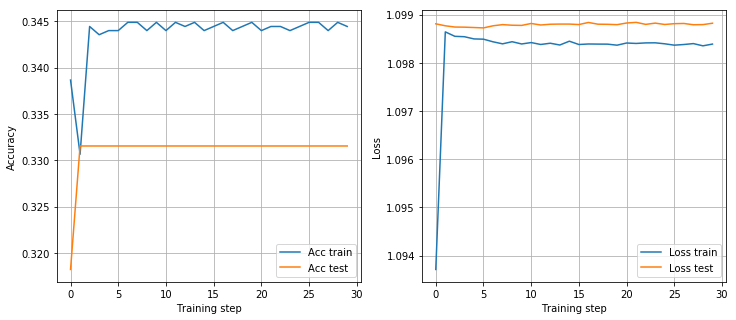

In [39]:
plt.figure(figsize=(12,5))

plot_acc_loss(acc_train, acc_test, 1, "Training step","Accuracy","Acc train vs test","Acc train","Acc test")
plot_acc_loss(loss_train, loss_test, 2, "Training step","Loss","Loss train vs test","Loss train","Loss test")


# Part 2

Modify the optimization loop so that each batch is normalized before feeding it to the optimization step according to the following spec:

- consider only $X^{i}$ in the current batch
- $X^{i}$: image $i$
- $X^{i}_{j|k}$: channel $k$ of pixel $j$ in image $i$
- $S^i$: image $i$ standardized

In pixel wise standardization, each pixel has zero mean and std=1 across the dataset:

- $\mu = \frac{1}{N}\sum_{i,j,k} X^{i}_{j|k}$
- $\sigma = \frac{1}{N}\sum_{i,j,k}^{N-1}(X^{i}_{j|k}-\mu_{j|k})^2$

So that:

$$S^{i}_{j|k} = \frac{1}{\sigma + 10^{-6}}(X^{i}_{j|k} - \mu)$$


The $10^{-6}$ is to avoid the case of zero variance

you must also plot:

- accuracy and loss curves for train and test separately, which should look better than the previous

![](Images/lab_batch_02.png)

- for only train, the accuracy and loss curves of both experiments, looking like this

![](Images/lab_batch_03.png)


In [49]:
tX, ty, init, accuracy, training_op, loss = build_model(n_filters, filter_size, dense_size, img_size, n_channels)

('y_proba', TensorShape([Dimension(None), Dimension(3)]))
('ty', TensorShape(None))
('y_hat', TensorShape([Dimension(None)]))
-- weights shape --
(4, 4, 3, 15)
(15,)
(15360, 16)
(16,)
(16, 3)
(3,)


In [54]:
sx_train = np.r_[[(i-np.mean(i))/np.std(i) for i in x_train]]
sx_test = np.r_[[(i-np.mean(i))/np.std(i) for i in x_test]]

In [55]:
num_examples = len(x_train)
bacc_train, bacc_test = [], []
bloss_train, bloss_test = [], []
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
                
        idxs = np.random.permutation(len(sx_train))
        eacc, eloss = [], []
        for iteration in range(num_examples // batch_size):
            
            
            X_batch = sx_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]
            y_batch = y_train[idxs][iteration*batch_size:iteration*batch_size+batch_size]
            
            
            _, _eacc, _eloss = sess.run([training_op, accuracy, loss], feed_dict={tX: X_batch, ty: y_batch})
           
            eacc += [_eacc]
            eloss += [_eloss]
        
        _eacct, _elosst = sess.run([accuracy, loss], feed_dict={tX: sx_test, ty: y_test})
        bacc_train += [np.mean(eacc)]
        bacc_test  += [_eacct]
        bloss_train += [np.mean(eloss)]
        bloss_test  += [_elosst]
      
        print "epoch: %3d"%(epoch+1), "  train accuracy: %.4f"%bacc_train[-1], "  test accuracy: %.4f"%bacc_test[-1], "  train loss: %.4f"%bloss_train[-1], "  test loss: %.4f"%bloss_test[-1]

epoch:   1   train accuracy: 0.5460   test accuracy: 0.6365   train loss: 0.9839   test loss: 0.9018
epoch:   2   train accuracy: 0.6393   test accuracy: 0.6338   train loss: 0.8964   test loss: 0.8939
epoch:   3   train accuracy: 0.6938   test accuracy: 0.6751   train loss: 0.8523   test loss: 0.8624
epoch:   4   train accuracy: 0.7094   test accuracy: 0.6791   train loss: 0.8360   test loss: 0.8666
epoch:   5   train accuracy: 0.7246   test accuracy: 0.6871   train loss: 0.8193   test loss: 0.8435
epoch:   6   train accuracy: 0.7536   test accuracy: 0.7230   train loss: 0.7938   test loss: 0.8245
epoch:   7   train accuracy: 0.7585   test accuracy: 0.6884   train loss: 0.7877   test loss: 0.8487
epoch:   8   train accuracy: 0.7902   test accuracy: 0.7097   train loss: 0.7621   test loss: 0.8271
epoch:   9   train accuracy: 0.8112   test accuracy: 0.7270   train loss: 0.7433   test loss: 0.8205
epoch:  10   train accuracy: 0.8237   test accuracy: 0.7337   train loss: 0.7288   test los

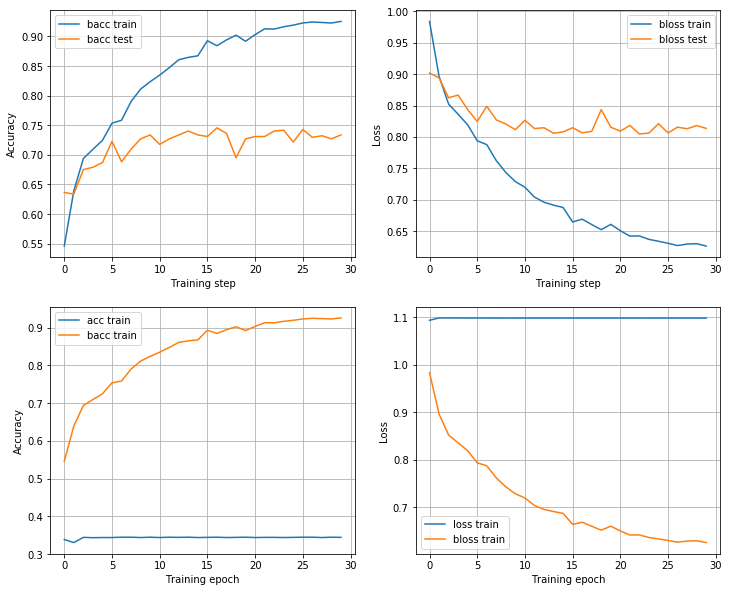

In [59]:
plt.figure(figsize=(12,10))

plot_acc_loss(bacc_train, bacc_test, 1,"Training step","Accuracy","Bacc train vs test","bacc train","bacc test")
plot_acc_loss(bloss_train, bloss_test, 2, "Training step","Loss","Bloss train vs test","bloss train","bloss test")
plot_acc_loss(acc_train, bacc_train, 3, "Training epoch","Accuracy","Bacc vs acc train","acc train","bacc train")
plot_acc_loss(loss_train, bloss_train, 4, "Training epoch","Loss","Bloss vs loss train","loss train","bloss train")
